Matthew Dolinka

Document Classification of Wikipedia Articles

Introduction:

Hello, today in this article we are going to discuss various methods to classify wikipedia articles using
both supervised and unsupervised learning models.

We are going to be using a hierarchical Clustering approach to classification as well
as a linear classifier approach using weights determined from tf-idf values from gathered
training data (wikipedia articles) 

Required imports:

In [394]:
import pandas as pd
import numpy as np
import copy
import re
import json
import requests
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

Scraping the Data:

Scraping articles and titles from wikipeida turns out to not be as difficult as one might expect.
Wikipedia has a user interface called the MediaWiki API. To make use of this API, use the
webaddress "https://en.wikipedia.org/w/api.php" and send the features that you want
using the params feature of python's requests module

This is a function that is designed to take in a category from wikipedia and recursively unpack it, returning a list of the category's pages and the pages of its subcategories. However this unpacking only occurs up to a certain level to avoid
performance problems. Unless you want a crazy amount of results or are okay with waiting for a while, I recomend that you leave level at 1 when you
call the funtion.

In [2]:
#category is for example of the form "Category:Physics"

#cmnamespace to 0 is to only get proper wikipedia articles,
#and 14 is to get categories
def unpack_category(category, level):
    raw = requests.get(
    "https://en.wikipedia.org/w/api.php",
    params={
        'action': 'query',
        'format': 'json',
        'list': 'categorymembers',
        'cmtitle': category,
        'cmlimit': 500,
        'cmnamespace': '0|14'
        }
    ).json()
        
    #two buckets, titles for page titles and categories
    #for categories format is "Category:categoryname"
    titles = []
    categories = []
    
    for cat in raw['query']['categorymembers']:
        title = cat['title']
        #see if the title is actually a category using regular expressions
        if re.search('Category:.*', title):
            categories.append(title)
        else:
            titles.append(title)
        
    #now recurse over each of the categories and merge with the titles list
    if level > 0:
        for cat in categories:
            titles = titles + unpack_category(cat, level - 1)
    
    return titles

Before we can do any thing with article text, first we have to actually get the titles of the articles we want.
This function returns a list of randomly samples wikipedia titles. Note that we can only request a maximum of 500
titles at a time per wikipedia's limitations. In order to gather any more than 500 articles, you have
to make multiple requests and merge them.

In [3]:
def generate_random_wiki_titles(limit):
    result = []
    
    #rnnamespace 0 is used to only get proper wikipedia articles
    #ie, no category or user pages
    raw = requests.get(
    "https://en.wikipedia.org/w/api.php",
    params={
        'action': 'query',
        'format': 'json',
        'list': 'random',
        'rnlimit': limit,
        'rnnamespace': 0

        }
    ).json()
    
    for json_dict in raw['query']['random']:
        result.append(json_dict['title'])
    
    return result

In [4]:
random_titles = list(set(generate_random_wiki_titles(500) + generate_random_wiki_titles(500)))

In [5]:
cs_titles = unpack_category('Category:Computer_science', 1)

In [6]:
baseball_titles = unpack_category('Category:Baseball', 1)

In [7]:
game_titles = unpack_category('Category:Video_games', 1)

In [545]:
game_titles[:25]

['Outline of video games',
 'List of most-played mobile games by player count',
 'Personalized video game',
 'Video game addiction in China',
 'Video game',
 'Outline of video games',
 'List of game companies in the United Kingdom',
 'List of video game developers',
 'List of independent video game developers',
 'List of video game publishers',
 'List of celebrities portrayed in video games',
 'List of video game designers',
 'List of video game musicians',
 'List of video game industry people',
 'List of Angry Video Game Nerd episodes',
 'List of video game collector and limited editions',
 'List of crossovers in video games',
 'List of video game crowdfunding projects',
 'List of Cyberathlete Professional League champions',
 'Comparison of dance pad video games',
 'Early Edu-Ware products',
 'List of esports games',
 'List of games at Funspot',
 'Glossary of video game terms',
 'List of level editors']

Now that we have our article titles, we can begin scraping the articles proper. Note that now
we have to make use of the "extracts" feature of the Media Wiki API.

This code is intended to take the html text from a wikipedia page, only taking the
bare text of the article without images or tags

In [462]:
def scrape_wikipage(title):
    page_data = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
        'action': 'query',
        'format': 'json',
        'utf8': True,
        'titles': title,
        'prop': 'extracts',
        'explaintext': True,
        }).json()
    
    result = next(iter(page_data['query']['pages'].values())) 
    return result['extract']
    
    

Here is an example of scraping the article text from one of our article categories

In [544]:
scrape_wikipage(baseball_titles[3])[:600]

'Baseball5 is variation of the game of baseball. There are five players on each team and each team has five innings. The World Baseball Softball Confederation proposed the game in 2018.\n\n\n== Rules and gameplay ==\n\n\n=== The field ===\n\nThe infield has a square shape, with a base in every corner.The distance in between bases is 13\nmeters or 42,5 feet. The fair territory has a square shape of 18 meters or 59 feet per side, in which one of the corners \ncoincides with the home plate. The batter’s box has a square shape of 3 meters (10 ft.) per side. It is placed outside of the fair \nterritory and is '

What we want to do now that we can scrape any wiki page's
text with just a title is to take random samples of titles
from our category lists above and collect the text in arrays for each category

This funtion here takes in a title list and returns an array of size limit of strings, where each string is randomly sampled 
from the given title list.

Note that we are sampling without replacement. The given titles list is deep copied so that the elements in the given
titles list are not affected

In [11]:
def sample_articles(titles, limit):
    titles = copy.deepcopy(titles)
    result = {}
    
    #ensure that we will not sample more than the number of titles
    if limit > len(titles):
        limit = len(titles)
    
    #takes a random article limit times (without replacement)
    for _ in range(limit):
        random_index = random.randint(0, len(titles) - 1)
        sampled_title = titles[random_index]
        
        #now drop the sampled title from titles
        del(titles[random_index])
        
        result[sampled_title] = scrape_wikipage(sampled_title)
        
    return result

Note that it can take some time to scrape the wikipedia articles. I strongly suggest that you
store the titles and articles locally, so that you do not have to keep requesting them from
Wikipedia; it can be quite time consuming and will not always work depending on 
the internet connection that you are using.

In [12]:
random_articles = sample_articles(random_titles,800)

In [13]:
game_articles = sample_articles(game_titles,400)

In [15]:
cs_articles = sample_articles(cs_titles,400)

In [16]:
baseball_articles = sample_articles(baseball_titles,400)

Find bag of words and cosine similarity between a set of documents documents:

Now, in order to make use of the article text for linear classification, we will
have to convert the document of strings into a Pandas DataFrame where the rows are the
titles of the documents and the columns correspond to every possible word that can
be found in all the documents in the document dictonary. The values in the table are the
number of occurances of each word for each document. This is important because later we
will have to use the rows of this table as feature vectors for our calculation of
cosine similarity and linear classification.

In [17]:
def bag_of_words(document_dict):
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorizer = CountVectorizer()
    matrix = count_vectorizer.fit_transform(list(document_dict.values()))
    
    doc_term_matrix = matrix.todense()
    df = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=list(document_dict.keys()))
    
    return df

In [18]:
df = bag_of_words(game_articles)

In [546]:
df.iloc[:12, [0,10,1000,2000,5000,5001,5002,5004]]

,00,016,advises,atomic,choiceno,corporation,corporations,corporeal,corps,corpse
Secret Paths (video game),0,0,0,0,0,0,0,0,0,0
Resident Evil 7: Biohazard,0,0,0,0,0,4,0,0,0,0
Project M (video game),0,0,0,0,0,0,0,0,0,0
Torn (video game),0,0,0,0,0,0,0,0,0,0
List of most expensive video game acquisitions,0,0,0,0,0,0,0,0,0,0
List of esports games,0,0,0,0,0,0,0,0,0,0
AstroFire,0,0,0,0,0,0,0,0,0,0
Warm Up!,0,0,0,0,0,0,0,0,0,0
Final Fantasy VIII,0,0,0,0,0,0,0,0,0,0
Cardinal of the Kremlin (video game),0,0,0,0,0,0,0,0,0,0


Next we need a metric to determine how similar any two documents are. The metric we will be
using for clustering is called cosine similarity. Cosine similarity is calculated using the feature
vectors derived earlier and produces a result between 0 (dissimilar) and 1 (similar) for every document

In [463]:
def df_cosine_similarity(word_bag):
    cosine_matrix = cosine_similarity(word_bag, dense_output=True)
    
    df = pd.DataFrame(cosine_matrix, 
                  columns=word_bag.index.tolist(), 
                  index=word_bag.index.tolist())
    
    return df

In [21]:
cs = df_cosine_similarity(df)

In [547]:
cs.iloc[:4, list(range(4))]

,Secret Paths (video game),Resident Evil 7: Biohazard,Project M (video game),Torn (video game)
Secret Paths (video game),1.000000,0.845076,0.808096,0.558492
Resident Evil 7: Biohazard,0.845076,1.000000,0.887837,0.595349
Project M (video game),0.808096,0.887837,1.000000,0.516431
Torn (video game),0.558492,0.595349,0.516431,1.000000


Clustering (Hierarchical Clustering):

This algorithm is an attempt to implement the idea of Hierarchical clustering.
Essentially the idea is that it can take in a dictionary of titles mapped to articles and
a second list of titles to start clustering around. The algorithm will start with these special
titles and find the documents in the given dictionary that are closest (cosine similarity) the the given document.
The closest document will be added to a cluster along with its closest neighbor and removed
from the overall pool of documents. As the cluster grows, new documents are compared to each document inside the
cluster and their cosine similarities are summed. The document that produces the overall highest cosine similarity
is adopted into the cluster and removed from the document pool. This is done until there are
no more documents to sample and the clusters are returned.

In [23]:
def clusterings(documents, starting_names):
    #deep copy documents so removal doesnt change what the user passed in
    documents = copy.deepcopy(documents)
    #generate matrix of cosine similarities
    cosine_matrix = df_cosine_similarity(bag_of_words(documents))
    
    clusters = []
    
    for name in starting_names:
        clusters += [[name]]
        #the onus is on the user to pass in document names
        #that are actually contained within the documents variable
        del documents[name]
    
    #sums up the cosine similarities of the newcomer to each
    #of the documents in docs
    def compare_cosine(newcomer, docs):
        result = 0
        for doc in docs:
            result += cosine_matrix[newcomer][doc]
        return result
    
    #the purpose of the i is to alternate between the different
    #clusters when comparing cosine values
    i = 0
    while len(documents) > 0:
        highest = 0
        contender = None
        for doc in documents:
            comp = compare_cosine(doc, clusters[i%len(clusters)])
            if comp >= highest:
                highest = comp
                contender = doc
        
        #add the nearest document to its appropriate cluster and
        #remove it from the documents dictionary
        clusters[i%len(clusters)].append(contender)
        del documents[contender]
        
        i += 1
        
    return clusters

Now let's test our clustering algorithm using the random article dataset that we gathered
earlier. It is important and most interesting to test using randomly gathered data
and not data gathered from categories because with clustering we will be able to
more easily appreciate the similarities between the gathered documents in the clusters.

In [24]:
#take a random sample
sample_titles = random.sample(list(random_articles), 800)
sample_dict = {}
for title in sample_titles:
    sample_dict[title] = random_articles[title]
len(sample_dict)

800

In [548]:
clusterings(sample_dict, random.sample(list(sample_dict),30))[:3]

[['Wordplay (musician)',
  'Enric Sagnier',
  'Millard Fillmore',
  'Thol. Thirumavalavan',
  'Stepan Khilkov',
  'William Howell Forbes',
  'Jacques-Antoine de Chambarlhac de Laubespin',
  'Anton Vodnik',
  'John Alexander Paul Macgregor',
  'Erik Lund-Isaksen',
  'Seán Conlan',
  'Peace Breaks Out',
  'Philip Mennell',
  'Richard Joseph Fitzgerald',
  'Sigmund Løvåsen',
  'Edward Moreno',
  'George Fenner (soldier)',
  'William Demas',
  '2009 Premier League Darts',
  '1996 San Diego mayoral election',
  "2015 European Diving Championships – Women's 10 metre platform",
  'Mohammadabad (34°02′ N 57°12′ E), Ali Jamal',
  'Aditya Babu',
  'Asfyj District',
  'Murlak',
  'Polar Libraries Colloquy',
  'Manoel José Dias'],
 ['Dennis Hampson',
  '2018 Italian general election',
  'European Public Prosecutor',
  '1988 Pakistani general election',
  'State of Aleppo',
  'Jamaican Maroons in Sierra Leone',
  'Chancellor of the Order of Australia',
  'Jean-Marie Beaupuy',
  'Dave Stocking',
  '

One thing you might notice is that we have to increase the sample size of articles
before we start to be able to notice significant similarities in the returned clusters.
Additonally, you are probably also going to want to increase the number of clusters
in such a way as to ensure that you have enough elements in each cluster.

The interesting thing about clustering is that it is a unsupervised modeling method
meaning that we do not have to supply any labels to our data. We can take any gathered set of
wikipedia articles and attempt to find similarities. One downside to this method is that
the algorithm has polynomial runtime meaning that as we increase the size of our dataset
even into the thousands, we will begin to run into significant performance problems, making
it difficult to get interesting results, as we want more and more data.

Linear Classification:

The next modeling method that we will be using is called linear classification.
Our goal with this model is to produce a series of weight vectors that will be 
used along with a set of feature vectors to classify a set of documents. The feature vectors
are arrays of word occurences for each word in every document in the sample.

First, let us define a function that will return a pandas dataframe of tf-idf values using a predetermined vocabulary

tf-idf is a method of measuring the significance for a term (word) in a set of
articles that controls for things such as the overuse of common words such as "the"
that can occur many times in any or all articles.

In [42]:
def find_tf_idf(documents, vocabulary):
    vect = TfidfVectorizer(
        vocabulary=vocabulary,
        use_idf=True,
    )
    X = vect.fit_transform(list(documents.values()))
    
    df = pd.DataFrame(
        X.todense(),
        columns=vect.get_feature_names(),
        index=list(documents.keys())
    )
    return df
                  

In [271]:
find_tf_idf(
    {"Doc1":'The cow eats cheese',"Doc2": 'I see a witch',"Doc3": 'Cheese is made of cow milk'},
    ['cow', 'the', 'cheese', 'a']
)

,cow,the,cheese,a
Doc1,0.517856,0.680919,0.517856,0.0
Doc2,0.000000,0.000000,0.000000,0.0
Doc3,0.707107,0.000000,0.707107,0.0


In [549]:
find_tf_idf(game_articles,['and', 'the', 'gameplay']).iloc[:12]

,and,the,gameplay
Secret Paths (video game),0.345080,0.937655,0.041501
Resident Evil 7: Biohazard,0.371140,0.928430,0.016532
Project M (video game),0.445460,0.892025,0.076534
Torn (video game),0.249472,0.968382,0.000000
List of most expensive video game acquisitions,0.000000,1.000000,0.000000
List of esports games,0.346618,0.938006,0.000000
AstroFire,0.000000,0.000000,0.000000
Warm Up!,0.678350,0.658293,0.326330
Final Fantasy VIII,0.389628,0.920834,0.015938
Cardinal of the Kremlin (video game),0.293301,0.948762,0.117580


Now lets create samples from our category data sets for training and for validation. We will take 3/4th of the values for training and 1/4th of the values for validation from each category

The reason that it is important to split our data this way is that we have to make sure
that the way the we test our model is not subject to bias due to reusing articles for both
training and testing the model.

In [98]:
def train_test_split(documents):
    keys = copy.deepcopy(list(documents.keys()))
    random.shuffle(keys)
    
    result1 = {}
    for i in range(int(3*len(keys)/4)):
        result1[keys[i]] = documents[keys[i]]
        
    result2 = {}
    for i in range(int(3*len(keys)/4), len(keys)):
        result2[keys[i]] = documents[keys[i]]
    
    return (result1, result2)

In [99]:
train_test_split({'a': 'aaa', 'b': "bbb", 'c':'ccc', 'd':'ddd'})

({'c': 'ccc', 'a': 'aaa', 'd': 'ddd'}, {'b': 'bbb'})

Now we will store the data for each category in a tuple of the form (training, validation)

In [100]:
cs_data = train_test_split(cs_articles)

In [104]:
game_data = train_test_split(game_articles)

In [105]:
baseball_data = train_test_split(baseball_articles)

This function takes a set of documents that one wishes to classify and a list of categories
(themselves lists of documents) and produces a list of len(categories) weight vectors that are
used to classify the document in the linear_classify function father down. The categories variable is of the form
{category_label:{doc1name:text, doc2name:text}, ...}.

The bag parameter is just the bag of words in pandas dataframe form that we get from calling our
bag_of_words function with a dictionary of article titles mapped to article text.

This function will return a dict of the form {category1:weight vector, category2:weight vector, ...}

In [421]:
def produce_weights(bag, categories, weight_scalars={}):
    weight_vectors = {}
    for category in categories:
        tfidf = find_tf_idf(categories[category], list(bag.columns.values))
        weight = tfidf.sum()
        
        #now apply the modified weights
        if category in weight_scalars:
            for term,scalar in weight_scalars[category].items():
                if term in weight:
                    weight[term] = weight[term]*scalar
        
        weight_vectors[category] = weight
    
    return weight_vectors

Now we have an array of n weights, where n is the number of entries into the categories dictionary that we passed in.
These category values are used as training data that is intended to work with the documents that we are attempting
to classify. After a call to the produce_weights function we now have a list of n weight vectors that represent the
sum of tfidf values for all of the words in documents, counted for each of the categories we are training with.

Now the next step is to plug our bag of words (with each row representing the feature vector of each documents)
into our linear classifier function

This function will take each of the weight vectors and for each feature vector, x, take the dot product between x and the weight vectors and return the category label of the weight vector that makes the highest score.

In [255]:
def linear_classifier(bag, weights, terms_to_drop=[]):
    results = {}
    
    #find the most common terms among all weights and drop them
    
    
    #drop unnecesary terms
    for term in terms_to_drop:
        if term in bag:
            bag = bag.drop(term,axis=1)
            
            for label,weight in weights.items():
                weights[label] = weight.drop(term)
    
    for index,row in bag.iterrows():
        max_label = ''
        max_value = 0
        
        for label,weight_vector in weights.items():
            dot = np.dot(row,weight_vector)
            if dot >= max_value:
                max_label = label
                max_value = dot
        
        results[index] = max_label
        
    return results

Lets do a simple test of the accuracy of our classifier function. For this basic
test we'll just use game data for our unknown documents and we will use
a variety of categories for training data

In [256]:
game_test_weights = produce_weights(bag_of_words(game_data[1]), {'cs':cs_data[0], 'game':game_data[0], 'baseball':baseball_data[0]})

In [257]:
game_test_classifications = linear_classifier(bag_of_words(game_data[1]), game_test_weights)

In [555]:
def picture_single_result(results):
    num_game = 0
    num_baseball = 0
    num_cs = 0
    
    for title,label in results.items():
        if label == "game":
            num_game += 1
        elif label == "cs":
            num_cs += 1
        elif label == "baseball":
            num_baseball += 1
            
    
    #create graphs
    objects = ('Video Games', 'Computer Science', 'Baseball')
    y_pos = np.arange(len(objects))
    performance = [num_game, num_cs, num_baseball]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Number')
    plt.title('Number of classifications per Category')

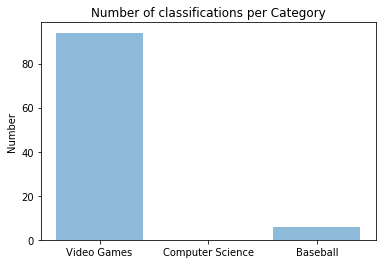

In [556]:
picture_single_result(game_test_classifications)

As you can see, most of the articles are classified as game as we would expect.
Now lets do the same thing but mix in a few other categories as well and just eyeball
the results for now.

In [490]:
mixed_bag = bag_of_words(dict(baseball_data[1], **dict(game_data[1], **cs_data[1])))

In [491]:
mixed_test_weights = produce_weights(
    mixed_bag,
    {'cs':cs_data[0], 'game':game_data[0], 'baseball':baseball_data[0]}
)

In [492]:
mixed_test_classifications = linear_classifier(mixed_bag, mixed_test_weights)

We will now provide a function to observe the results

In [552]:
def results_stats(results, data):
    num_game = 0
    num_baseball = 0
    num_cs = 0
    
    game_accurately_classified = 0
    cs_accurately_classified = 0
    baseball_accurately_classified = 0
    
    for title,label in results.items():
        if label == "game":
            num_game += 1
        elif label == "cs":
            num_cs += 1
        elif label == "baseball":
            num_baseball += 1
            
    for title,text in data[0][1].items():
        if results[title] == "cs":
                cs_accurately_classified += 1
                    
    for title,text in data[1][1].items():
        if results[title] == "game":
                game_accurately_classified += 1
                    
    for title,text in data[2][1].items():
        if results[title] == "baseball":
                baseball_accurately_classified += 1
                    
    stringout = "There were " +  str(len(results.keys())) + " classifications" + "\n" + \
    "game classifications: " + str(num_game) + "\n" + \
    "cs classifications: " + str(num_cs) + "\n" + \
    "baseball classifications: " + str(num_baseball) + "\n\n" + \
    "percent game articles correctly classified: " + str(game_accurately_classified/len(data[0][1])) + "\n" + \
    "percent cs articles correctly classified: " + str(cs_accurately_classified/len(data[1][1])) + "\n" + \
    "percent baseball articles correctly classified: " + str(baseball_accurately_classified/len(data[2][1])) + "\n"
    
    #create graphs
    objects = ('Video Games', 'Computer Science', 'Baseball')
    y_pos = np.arange(len(objects))
    performance = [game_accurately_classified, cs_accurately_classified, baseball_accurately_classified]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Percentage')
    plt.title('Percentage articles Correctly Classified')
    
    return stringout

Interestingly enough, it seems that there is a bias towards classifying articles
as "game" using our bare tf-idf method. Lets see the stats on this classification.

'There were 294 classifications\ngame classifications: 278\ncs classifications: 0\nbaseball classifications: 16\n\npercent game articles correctly classified: 1.0101010101010102\npercent cs articles correctly classified: 0.0\npercent baseball articles correctly classified: 0.14736842105263157\n'

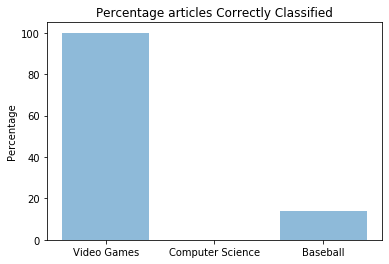

In [495]:
results_stats(mixed_test_classifications ,[cs_data,game_data,baseball_data])

Clearly there is a great bias being given to the game label using this method while cs classifications are excedingly rare
(or none)

Let's try  making a small change here. Now we are going to tell our linear
classifier to drop some terms from the calculation. In particular, we are going
to choose common and unhelpful terms such as "the" and "and".

In [496]:
mixed_test_weights_2 = produce_weights(
    mixed_bag,
    {'cs':cs_data[0], 'game':game_data[0], 'baseball':baseball_data[0]}
)

In [497]:
mixed_test_classifications_2 = linear_classifier(
    mixed_bag, mixed_test_weights_2, terms_to_drop=['the','and','of','a']
)

'There were 294 classifications\ngame classifications: 189\ncs classifications: 17\nbaseball classifications: 88\n\npercent game articles correctly classified: 1.0101010101010102\npercent cs articles correctly classified: 0.17\npercent baseball articles correctly classified: 0.8736842105263158\n'

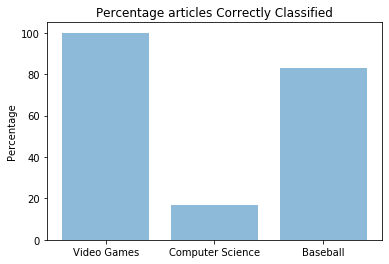

In [499]:
results_stats(mixed_test_classifications_2 ,[cs_data,game_data,baseball_data])

Awesome, now we are already getting much more accuracy when it comes to baseball,
and a bit more when it comes to computer science articles. But let's
try one more thing.

We are going to manipulate the weighting process to be biased towards certain
terms in certain categories. For example we can take the term "deathmatch" and
associate it with video games or we can take "string" and associate 
it with computer science.

In [500]:
mixed_test_weights_2["cs"]["string"]

1.0486484851723943

In [501]:
mixed_test_weights_3 = produce_weights(
    mixed_bag,
    {'cs':cs_data[0], 'game':game_data[0], 'baseball':baseball_data[0]},
    weight_scalars={
        "cs":{
            "string":20, "data":15, "orthogonality":15, 'programming':15, "vector":30,
            "professor":15, "science":25, "bits":9
        },
    }
)

In [502]:
mixed_test_weights_3["cs"]["string"]

20.972969703447887

In [503]:
mixed_test_classifications_3 = linear_classifier(
    mixed_bag, mixed_test_weights_3, terms_to_drop=['the','and','of','a']
)

'There were 294 classifications\ngame classifications: 154\ncs classifications: 53\nbaseball classifications: 87\n\npercent game articles correctly classified: 1.0101010101010102\npercent cs articles correctly classified: 0.53\npercent baseball articles correctly classified: 0.8736842105263158\n'

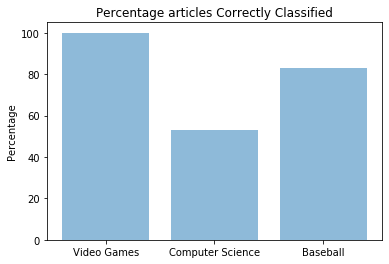

In [504]:
results_stats(mixed_test_classifications_3 ,[cs_data,game_data,baseball_data])

As you can see changing the weights of certain key terms can massively change the accuracy of the 
classification system

To avoid overfitting let's see how our current model works with a different set of articles

In [466]:
game_articles_2 = sample_articles(game_titles,400)

In [467]:
cs_articles_2 = sample_articles(cs_titles,400)

In [468]:
baseball_articles_2 = sample_articles(baseball_titles,400)

In [476]:
game_data_2 = train_test_split(game_articles_2)

In [477]:
cs_data_2 = train_test_split(cs_articles_2)

In [478]:
baseball_data_2 = train_test_split(baseball_articles_2)

In [505]:
mixed_bag_2 = bag_of_words(dict(game_data_2[1], **cs_data_2[1], **baseball_data_2[1]))

In [506]:
mixed_test_weights_4 = produce_weights(
    mixed_bag_2,
    {'cs':cs_data_2[0], 'game':game_data_2[0], 'baseball':baseball_data_2[0]},
    weight_scalars={
        "cs":{
            "string":20, "data":15, "orthogonality":15, 'programming':15, "vector":30,
            "professor":15, "science":25, "bits":9
        },
    }
)

In [507]:
mixed_test_classifications_4 = linear_classifier(
    mixed_bag_2, mixed_test_weights_4, terms_to_drop=['the','and','of','a']
)

'There were 288 classifications\ngame classifications: 164\ncs classifications: 53\nbaseball classifications: 71\n\npercent game articles correctly classified: 1.0\npercent cs articles correctly classified: 0.5353535353535354\npercent baseball articles correctly classified: 0.7555555555555555\n'

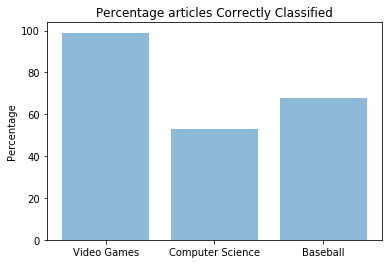

In [508]:
results_stats(mixed_test_classifications_4 ,[cs_data_2,game_data_2,baseball_data_2])

On a different data set you can see that it performs very similarly, good to see!

Finally, lets compare our linear classification model to the clustering model and see
what the results look like. We will be partitioning the data into three clusters, 
starting with a member of each category

In [519]:
game_representative = random.choice(list(game_data[1].keys()))

In [520]:
cs_representative = random.choice(list(cs_data[1].keys()))

In [521]:
baseball_representative = random.choice(list(baseball_data[1].keys()))

In [522]:
clusters = clusterings(
    dict(cs_data[1],**game_data[1], **baseball_data[1]),
    [game_representative, cs_representative, baseball_representative]
)

In [538]:
def analyze_cluster(cluster):
    num_games = 0
    num_cs = 0
    num_baseball = 0

    for title in cluster:
        if title in game_data[1]:
            num_games += 1
        elif title in cs_data[1]:
            num_cs += 1
        elif title in baseball_data[1]:
            num_baseball += 1
           
    #create graph
    objects = ('Video Games', 'Computer Science', 'Baseball')
    y_pos = np.arange(len(objects))
    performance = [num_games, num_cs, num_baseball]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Number of Articles')
    plt.title('Number of items in cluster')
    

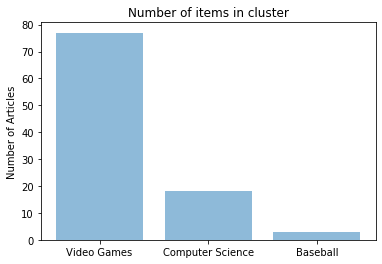

In [539]:
analyze_cluster(clusters[0])

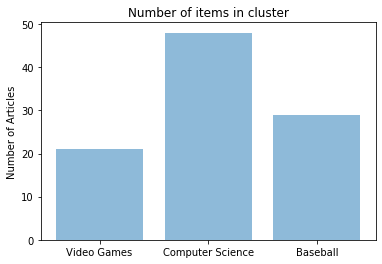

In [540]:
analyze_cluster(clusters[1])

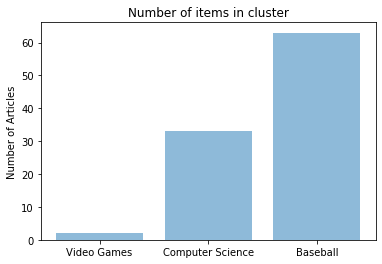

In [541]:
analyze_cluster(clusters[2])